In [255]:
# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

In [256]:
# Define the stock ticker symbol and date range
start_date = "2015-01-01"
end_date = "2019-12-31"

snp_benchmark_ticker = "^GSPC"
# List of MAANG stock tickers
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']

In [257]:
# Strategy rationale
# 1. Price-to-Earnings (P/E) Ratio:
# •	Definition: The P/E ratio shows how much investors are willing to pay for a company's earnings. High-growth companies typically have higher P/E ratios.
# •	Reasonable Threshold for MAANG:
    # o	< 50: Tech companies generally have higher P/E ratios, but anything above 50 may suggest overvaluation (relative to historical norms for these stocks).
    # o	For value-oriented strategies, you may go lower, but for growth stocks like MAANG, this threshold is appropriate.

# 2. Revenue Growth:
# •	Definition: Revenue growth indicates how much the company's sales are increasing. High-growth companies should show consistent revenue growth over time.
# •	Reasonable Threshold for MAANG:
#     o	> 15% YoY (Year-over-Year): For the MAANG group, anything above 10% revenue growth is considered strong, though some of these companies could exceed 20% or more. This ensures you’re capturing growing businesses, essential for growth-focused investing.


In [258]:
# Download historical price data for MAANG and S&P 500
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
snp_benchmark_data = yf.download(snp_benchmark_ticker, start=start_date, end=end_date)['Adj Close']

# Function to get quarterly financial data using yfinance
def get_quarterly_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    financials = {
        'P/E Ratio': stock.info.get('trailingPE', np.nan),
        'Revenue Growth': stock.info.get('revenueGrowth', np.nan)
    }
    return financials

# Remove timezone information (make datetime naive)
data.index = data.index.tz_localize(None)
snp_benchmark_data.index = snp_benchmark_data.index.tz_localize(None)

# Generate quarterly dates for rebalancing
dates = pd.date_range(start=start_date, end=end_date, freq='Q')

adjusted_dates = []
for date in dates:
    # If the date is not in the data, shift to the next available date
    if date not in data.index:
        nearest_idx = data.index.get_indexer([date], method='nearest')[0]
        adjusted_dates.append(data.index[nearest_idx])
    else:
        adjusted_dates.append(date)

# Store portfolio value and S&P 500 performance
portfolio_value = pd.Series(index=data.index, dtype=float)
snp_benchmark_value = snp_benchmark_data / snp_benchmark_data.iloc[0]  # Normalize to 1 at start

# Initial cash amount to start with is $1 million
initial_cash = 1000000

# Set portfolio value at the first available date to the initial cash amount
first_trading_day = data.index[0]
portfolio_value[first_trading_day] = initial_cash

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [259]:
# Criteria for fundamental selection
criteria = {
    'P/E Ratio': 100,
    'Revenue Growth': 0.15,
}
stop_loss_threshold = 0.15
position_reduce_factor = 0.5  # Reduce the position by 50% on stop-loss trigger

# Simulate rebalancing the portfolio on a quarterly basis
for date in adjusted_dates:
    fundamental_data = {}
    for ticker in tickers:
        try:
            financials = get_quarterly_fundamentals(ticker)
            fundamental_data[ticker] = financials
        except Exception as e:
            print(f"Error fetching fundamentals for {ticker}: {e}")
    
    # Convert fundamentals into DataFrame
    df_fundamentals = pd.DataFrame(fundamental_data).T
    
    # Filter stocks based on criteria
    selected_stocks = df_fundamentals[
        (df_fundamentals['P/E Ratio'] < criteria['P/E Ratio']) &
        (df_fundamentals['Revenue Growth'] > criteria['Revenue Growth'])
    ]
    
    # If no stocks meet criteria, skip the period
    if selected_stocks.empty:
        continue
    
    # Equal weight each stock in the portfolio
    weight = 1 / len(selected_stocks)
    
    # Get stock prices for the selected stocks on the rebalance date
    prices_at_rebalance = data.loc[date, selected_stocks.index]
    
    # Calculate the number of shares to buy based on weight and current portfolio value
    total_value = portfolio_value[date] if not pd.isna(portfolio_value[date]) else initial_cash
    shares = (total_value * weight) / prices_at_rebalance
    
    # Find the next available trading day if next_date is not valid
    if adjusted_dates.index(date) < len(adjusted_dates) - 1:
        next_date = adjusted_dates[adjusted_dates.index(date) + 1]
    else:
        next_date = end_date
    
    if next_date not in data.index:
        # Find the nearest available date for next_date
        nearest_idx = data.index.get_indexer([next_date], method='nearest')[0]
        next_date = data.index[nearest_idx]
    
    # Calculate future portfolio value with a stop-loss check
    future_prices = data.loc[next_date, selected_stocks.index]
    price_drop = (prices_at_rebalance - future_prices) / prices_at_rebalance

    # Calculate portfolio value at the next rebalance
    future_prices = data.loc[next_date, selected_stocks.index]
    portfolio_value[next_date] = (shares * future_prices).sum()

# Fill missing portfolio values by forward filling
portfolio_value.ffill(inplace=True)

# Normalize portfolio value to 1 at the start
portfolio_value /= portfolio_value.iloc[0]

In [260]:
### MAANG Benchmark Construction ###
# Create an equal-weighted MAANG portfolio for the entire period
equal_weights = 1 / len(tickers)
benchmark_value = (data * equal_weights).sum(axis=1)

# Normalize the benchmark to 1 at the start
benchmark_value /= benchmark_value.iloc[0]

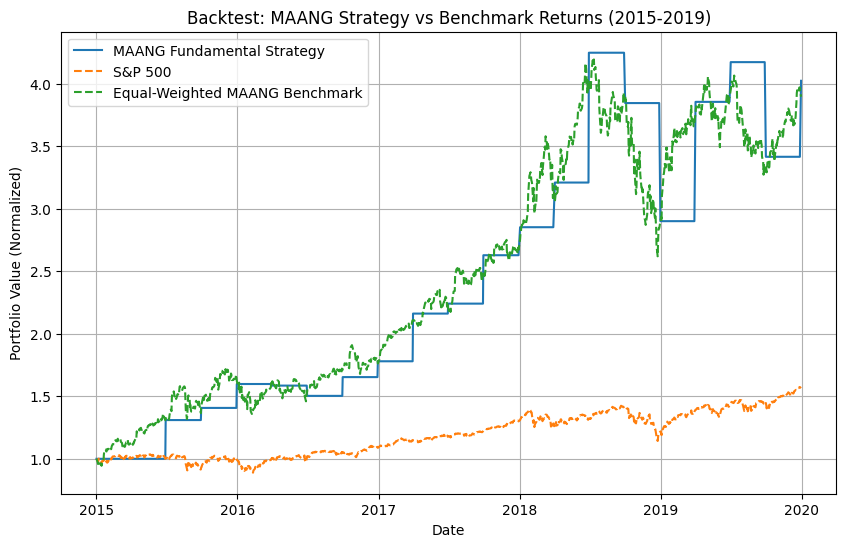

MAANG Strategy Return: 302.39%
Equal-Weighted MAANG Benchmark Return: 289.66%
S&P 500 Benchmark Return: 56.51%


In [261]:
# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(portfolio_value, label='MAANG Fundamental Strategy')
plt.plot(snp_benchmark_value, label='S&P 500', linestyle='--')
plt.plot(benchmark_value, label='Equal-Weighted MAANG Benchmark', linestyle='--')
plt.title('Backtest: MAANG Strategy vs Benchmark Returns (2015-2019)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate basic performance metrics
maang_return = (portfolio_value.iloc[-1] - portfolio_value.iloc[0]) / portfolio_value.iloc[0]
benchmark_return = (benchmark_value.iloc[-1] - benchmark_value.iloc[0]) / benchmark_value.iloc[0]
sp500_return = (snp_benchmark_value.iloc[-1] - snp_benchmark_value.iloc[0]) / snp_benchmark_value.iloc[0]

print(f"MAANG Strategy Return: {maang_return * 100:.2f}%")
print(f"Equal-Weighted MAANG Benchmark Return: {benchmark_return * 100:.2f}%")
print(f"S&P 500 Benchmark Return: {sp500_return * 100:.2f}%")

In [262]:
def BASS(portfolio_returns, benchmark_returns):
    #Prepare data with returns. Assumption is normal returns
    df = pd.DataFrame()
    df['portfolio_returns'] = portfolio_returns
    df['benchmark_returns'] = benchmark_returns
    df = df.dropna()

    #Calculate Beta
    cov = df['benchmark_returns'].cov(df['portfolio_returns'])
    print('cov:', round(cov,4))
    var = df['benchmark_returns'].var()
    print('var:', round(var,4))
    beta = cov/var
    beta = round(beta, 2)
    # print(beta)

    # Calculate Beta - make a returns covariance matrix
    # returns = df[['stock_returns', 'benchmark_returns']]
    # #Make a cov matrix
    # matrix = returns.cov()
    # #Select the variance and covariance to calculate beta
    # beta = matrix.iat[1,0] / matrix.iat[1,1]
    # beta = round(beta, 2)
    # print(beta)

    #Calculate Alpha
    #Can be calculated using annualised returns or absolute yearly returns.
    #If more than a year's data, can use CAGR i.e. ((Final Price / Initial Price) ^ (1/t)) - 1
    #Assuming risk-free rate is 0
    benchmark_yearly_returns = (df['benchmark_returns'].mean()*252)
    stock_yearly_returns = (df['portfolio_returns'].mean()*252)
    alpha = (stock_yearly_returns - beta * benchmark_yearly_returns)*100
    alpha = round(alpha,2)
    # print(alpha)

    #Calculate std dev of stock
    std_dev = (df['portfolio_returns'].std()) * 100
    std_dev = round(std_dev, 2)
    # print(std_dev)

    #Calculate Sharpe ratio of stock
    #SR = Mu/Sigma
    #Remember that Sharpe is only for a stock. It has nothing to do with Markets.
    #Used for comparing 2 stocks/portfolios
    avg_returns = df['portfolio_returns'].mean()
    std = df['portfolio_returns'].std()
    daily_SR = avg_returns / std

    #Convert daily to annual
    annual_SR = daily_SR * (252**0.5)
    annual_SR = round(annual_SR, 2)
    # print(annual_SR)

    return beta, alpha, std_dev, annual_SR

In [263]:
# Calculate daily returns for the portfolio and benchmark
portfolio_returns = portfolio_value.pct_change()
snp_benchmark_returns = snp_benchmark_value.pct_change()

# Call BASS function to calculate the metrics
beta, alpha, std_dev, sharpe_ratio = BASS(portfolio_returns, snp_benchmark_returns)

print(f"Beta: {beta}")
print(f"Alpha: {alpha}")
print(f"Standard Deviation: {std_dev}%")
print(f"Sharpe Ratio: {sharpe_ratio}")


cov: -0.0
var: 0.0001
Beta: -0.02
Alpha: 33.54
Standard Deviation: 2.17%
Sharpe Ratio: 0.97
